# Importazioni

In [17]:
import praw
from dotenv import load_dotenv
load_dotenv()
import os
import sys
sys.path.append('..')
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from multiprocessing import Pool
import logging
import yaml

# Creazione del dataset dei commenti

### Collegamento al profilo

In [18]:
reddit = praw.Reddit(
    client_id=os.getenv('reddit_client_id'),
    client_secret=os.getenv('reddit_client_secret'),
    user_agent=os.getenv('reddit_user_agent'),
    password=os.getenv('reddit_password'),
    username=os.getenv('reddit_username'))

### Estrazione dei commenti

In [19]:
def extract_comments(comment,post_id):
    comment_id = comment.id
    comment_body = comment.body
    comment_score = comment.score
    comment_replies = len(comment.replies)
    created_utc = comment.created_utc
    comment_author_name = comment.author.name if comment.author else "deleted"
    comment_author_id = comment.author.id if comment.author else "deleted"
    parent_author = comment.parent()
    if parent_author.id == post_id:
        parent_author_name = "OP"
        parent_author_id = "0"
    else:
        parent_author_name = parent_author.author.name if parent_author and parent_author.author else "deleted"
        parent_author_id = parent_author.author.id if parent_author and parent_author.author else "deleted"
    return comment_id, comment_body, comment_score, comment_replies, created_utc, comment_author_id, comment_author_name, parent_author_id, parent_author_name

In [20]:
def x(post_ids):
    post_to_download = []
    if not os.path.exists('../reddit_comments.csv'):
        return post_ids
    df = pd.read_csv('../reddit_comments.csv', encoding='utf-8')
    df_values = df['post_id'].values
    for post_id in post_ids:
        if post_id not in df_values:
            post_to_download.append(post_id)
    return post_to_download

post_ids = ['17z2hci', '1bulhj9', '1b6cg4q', '17lese9', '1cwqkqe', '10v8sey', '197vo6o', '1d5h5h6','19aeo2k']

first_len = len(post_ids)

fieldnames = [
    'comment_id', 
    'comment_author_id', 
    'comment_author_name', 
    'comment_parent_id', 
    'comment_parent_name', 
    'comment_score', 
    'comment_replies', 
    'comment_posted_time', 
    'comment_body',
    'post_id',
    'post_title',
    'post_url',
    'post_subreddit'
]

post_ids = x(post_ids)
second_len = len(post_ids)

if second_len > first_len:
    mode = 'w+'
else:
    mode = 'a+'


# Open the file in append mode
with open('../reddit_comments.csv', mode, newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames, quoting=csv.QUOTE_MINIMAL)
    if mode == 'w+':
        writer.writeheader()

    for post_id in post_ids:
        rows = []
        i = 1
        submission = reddit.submission(post_id)
        submission.comments.replace_more(limit=30)
        post_title = submission.title
        post_id = submission.id
        post_url = submission.url
        post_subreddit = submission.subreddit.name
        comments = submission.comments.list()
        length = len(comments)
        print(f"Processing post {post_title}\n", end='\r')
        for comment in comments:
            print(f"Processed {(i/length*100):.2f}% of comments", end='\r')
            try:
                comment_id, comment_body, comment_score, comment_replies, created_utc, comment_author_id, comment_author_name, parent_author_id, parent_author_name = extract_comments(comment,post_id)
                row = {
                    'comment_id' : comment_id, 
                    'comment_author_id' : comment_author_id,
                    'comment_author_name' : comment_author_name,
                    'comment_parent_id' : parent_author_id,
                    'comment_parent_name' : parent_author_name,
                    'comment_score' : comment_score,
                    'comment_replies' : comment_replies,
                    'comment_posted_time' : created_utc,
                    'comment_body'  : comment_body,
                    'post_id' : post_id,
                    'post_title' : post_title,
                    'post_url' : post_url,
                    'post_subreddit' : post_subreddit
                }
                rows.append(row)
            except Exception as e:
                pass
            i += 1
        writer.writerows(rows)

# Analisi dei grafi

In [21]:
comments_df = pd.read_csv('../reddit_comments.csv')
print(f'Numero di commenti: {comments_df.size}')
comments_df.head()

Numero di commenti: 52351


,comment_id,comment_author_id,comment_author_name,comment_parent_id,comment_parent_name,comment_score,comment_replies,comment_posted_time,comment_body,post_id,post_title,post_url,post_subreddit
0,k9yfohd,209w6fpg,moonwave91,0,OP,160,2,1.700439e+09,Il vero problema è l'immensa orda di giornalis...,17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
1,k9xjbzd,deleted,deleted,0,OP,311,3,1.700426e+09,"Non è un idiota l'ex ragazzo, è un assassino, ...",17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
2,k9zies2,e5pmjzs5c,MainDelay9804,0,OP,21,0,1.700459e+09,Sono sti ragazzetti sui social che ormai han p...,17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
3,k9xb0xr,utwr8mto,AlessandroIT,0,OP,82,1,1.700422e+09,"Non fatevi influenzare dai post, continuate ad...",17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5
4,k9xmjhd,49phg2z0,CthulhuParty,0,OP,89,1,1.700427e+09,ti da fastidio perchè percepisci giustamente c...,17z2hci,Ho visto troppi post sulla Giulia Cecchettin,https://www.reddit.com/r/Italia/comments/17z2h...,t5_2rbm5


### Creazione del grafo relativo a tutti i post

In [22]:
post_id_color = {}
post_id_title = {}
post_id_text = {}
np.random.seed(0)
color_list = ['yellow', 'green', 'blue', 'red', 'purple', 'orange', 'pink', 'brown']
l = len(color_list)
i = 0
for post_id in comments_df['post_id'].unique():
    post_id_color[post_id] = color_list[i%l]
    post_id_title[post_id] = comments_df[comments_df['post_id'] == post_id].iloc[0]['post_title'][0:20]
    i += 1

In [23]:
all_post_graph = ig.Graph(directed=True)
all_post_graph.add_vertex(name=comments_df.iloc[0]['comment_parent_id'], color='black', label = comments_df.iloc[0]['comment_parent_name'], post_id=comments_df.iloc[0]['post_id'])

for comment in comments_df.iloc[1:].iterrows():
    author_id = comment[1]['comment_author_id']
    author_name = comment[1]['comment_author_name']
    parent_id = comment[1]['comment_parent_id']
    comment_id = comment[1]['comment_id']
    post_id = comment[1]['post_id']
    comment_score = int(comment[1]['comment_score'])
    color = post_id_color[post_id]
    
    if author_id not in all_post_graph.vs['name']:
        if parent_id in all_post_graph.vs['name']:
            all_post_graph.add_vertex(name=author_id, label=author_name, color=color, post_id=post_id)
            all_post_graph.add_edge(author_id, parent_id, weight=comment_score, comment_id = comment_id)
    else:
        if parent_id in all_post_graph.vs['name'] and parent_id != author_id:
            all_post_graph.add_edge(author_id, parent_id, weight=comment_score, comment_id = comment_id)

all_post_graph.delete_vertices(['0','deleted'])

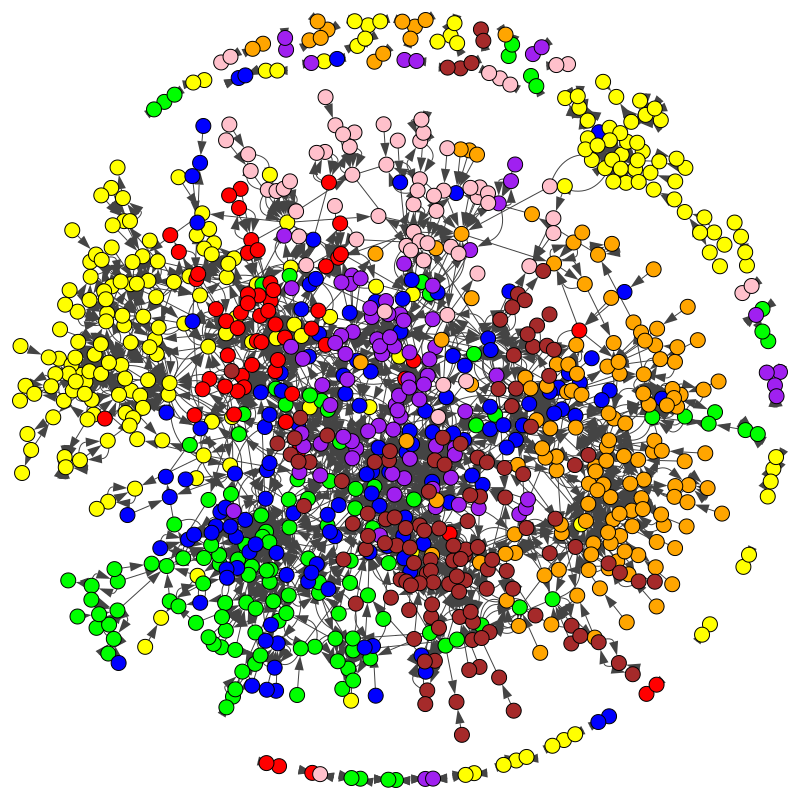

In [24]:
visual_style = {
    "vertex_label": None,
    "bbox": (800, 800),
    "vertex_size": 15,
}

all_post_graph.delete_vertices([v.index for v in all_post_graph.vs if v.neighbors() == []])
ig.plot(all_post_graph, **visual_style)

### Creazione e pulizia dei grafi separati

In [25]:
post_graphs = {}
visual_style = {
    "bbox": (1000, 1000),
    "vertex_label_size": 15
}
for post_id in set(all_post_graph.vs['post_id']):
    post_vertices = [v.index for v in all_post_graph.vs if v['post_id'] == post_id]
    subgraph = all_post_graph.subgraph(post_vertices)    
    post_graphs[post_id] = subgraph
    deleted_vertices = []
    for v in subgraph.vs:
        if v.neighbors() == []:
            deleted_vertices.append(v)

    subgraph.delete_vertices(deleted_vertices)
    ig.plot(subgraph,f'../graphs/post_graphs/post_graph_{post_id_title[post_id]}.png' ,**visual_style)

## Ricerca delle discussioni

In [26]:
def find_minimal_debate(graph):
    color_list = ['yellow', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'black','lightblue','lightgreen','lime','magenta','maroon','navy','olive','purple','silver','teal','white','yellow']
    i = 0
    for vertex in graph.vs:
        if vertex['debate_id'] == 0:
            color = color_list[i % len(color_list)]
            i += 1
            neighbors = vertex.neighbors()
            if neighbors != []:
                for vertex_neighbor in neighbors:
                    if vertex_neighbor['debate_id'] == 0:
                        try:
                            vertex_to_neighbor = graph.es.find(_source=vertex.index, _target=vertex_neighbor.index)
                        except:
                            vertex_to_neighbor = None
                        try:
                            neighbors_to_vertex = graph.es.find(_source=vertex_neighbor.index, _target=vertex.index)
                        except:
                            neighbors_to_vertex = None
                        if vertex_to_neighbor and neighbors_to_vertex:
                            vertex['color'] = color
                            vertex['debate_id'] = i
                            vertex_neighbor['color'] = color
                            vertex_neighbor['debate_id'] = i
                            break

def find_complete_discussion(vertex, graph):
    color = vertex['color']
    debate_id = vertex['debate_id']
    neighbors = vertex.neighbors()
    for neighbor in neighbors:
        if neighbor['debate_id'] != debate_id:
            try:
                vertex_to_neighbor = graph.es.find(_source=vertex.index, _target=neighbor.index)
            except:
                vertex_to_neighbor = None
            
            try:
                neighbors_to_vertex = graph.es.find(_source=neighbor.index, _target=vertex.index)
            except:
                neighbors_to_vertex = None

            if neighbors_to_vertex or (vertex_to_neighbor and neighbors_to_vertex):

                neighbor['color'] = color
                neighbor['debate_id'] = debate_id
                find_complete_discussion(neighbor, graph)

In [27]:
for single_post_graph in post_graphs.values():
    for vertex in single_post_graph.vs:
        vertex['debate_id'] = 0
    find_minimal_debate(single_post_graph)
    for vertex in single_post_graph.vs:
        if vertex['debate_id'] != 0:
            find_complete_discussion(vertex, single_post_graph)

    ig.plot(single_post_graph, f'../graphs/debate_graphs/debate_graph_{post_id_title[single_post_graph.vs[0]["post_id"]]}.png', **visual_style)

## Estrazione dei dataset a partire dai debate_graphs

In [28]:
i = 1
normalized_index = {}
for single_post_graph in post_graphs.values():
    post_id = single_post_graph.vs[0]['post_id']
    for debate_id in single_post_graph.vs['debate_id']:
        index = f'{post_id}_{debate_id}'
        if debate_id == 0:
            normalized_index[index] = 0
        else:
            if index not in normalized_index:
                normalized_index[index] = i
                i += 1

In [29]:
fieldnames = [
    'comment_id',
    'post_id',
    'debate_group',
    'comment_user_name',
    'commented_user_name',
    'comment_body',
    'comment_score'
    ]


with open(f'../debate_dataset.csv', 'a+', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for single_post_graph in post_graphs.values():
        i += 1
        post_id = single_post_graph.vs[0]['post_id']
        for edge in single_post_graph.es:
            source = single_post_graph.vs[edge.source]
            target = single_post_graph.vs[edge.target]
            if source['debate_id'] != 0 and target['debate_id'] != 0:
                debate_id = source['debate_id']
                index = f'{post_id}_{debate_id}'
                writer.writerow({
                    'comment_id': edge['comment_id'],
                    'post_id': source['post_id'],
                    'debate_group': normalized_index[index],
                    'comment_user_name': source['label'],
                    'commented_user_name': target['label'],
                    'comment_body': comments_df[comments_df['comment_id'] == edge['comment_id']].iloc[0]['comment_body'],
                    'comment_score': edge['weight']
                })

# Calcolo delle metriche

In [76]:
df = pd.read_csv('../debate_dataset.csv')
df.head()

,comment_id,post_id,debate_group,comment_user_name,commented_user_name,comment_body,comment_score
0,kxtjk7w,1bulhj9,1,T_JaM_T,theenkos,"No, la quantità di acqua che cade sotto forma ...",17
1,kxub8sy,1bulhj9,1,T_JaM_T,CosmoTwoFins,L'avevo sentito due o tre mesi fa in una trasm...,1
2,kxww2q1,1bulhj9,1,_The_Prov_,lore_mila_,L'unica a inquinare meno pro capite rispetto a...,2
3,kxuegzt,1bulhj9,1,_The_Prov_,Reforged_Narsil,"Si, chiedo scusa, il mio dato si riferiva solo...",2
4,kxtgmx2,1bulhj9,2,davidevernizzi,Dangerous-Practice-6,"Senza sarcasmo o polemica, cosa? Per come la v...",4


In [77]:
post_id_dict = {}
dataframe_list = []
for post_id in df['post_id'].unique():
    dataframe = df[df['post_id'] == post_id]
    dataframe_list.append(dataframe)
    post_id_dict[post_id] = dataframe

In [78]:
def create_graph_from_dataframe(dataframe):
    graph = ig.Graph(directed=True)
    graph.add_vertex(name='root', label='root')
    for comment in dataframe.iterrows():
        if comment[1]['comment_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['comment_user_name'], label=comment[1]['comment_user_name'])
        if comment[1]['commented_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['commented_user_name'], label=comment[1]['commented_user_name'])
        graph.add_edge(comment[1]['comment_user_name'], comment[1]['commented_user_name'])
    
    graph.delete_vertices('root')
    return graph

post_id_graph = {}
for dataframe in dataframe_list:
    graph = create_graph_from_dataframe(dataframe)
    post_id_graph[dataframe['post_id'].iloc[0]] = graph

## Metriche di valutazione dei grafi di dibattitio

**Metriche sul POST**

*Calcolo dell' average degree*
Calcolando l'average degree di ciascun post, è possibile farsi un'idea generale di quanto gli utenti tendono ad interagire tra di loro 

In [79]:
def degree_distribution(graph):
    degree = graph.degree()
    n = graph.vcount()
    degree = np.array(degree)

    return 1/n * sum(degree)

**Distribuzione dei gradi**

Questo grafico ci permette di osservare la distribuzione dei gradi di ogni nodo all'interno del grafo, offrendo una visione chiara del livello di interazione degli utenti. **Qual è la percentuale di utenti che hanno interagito poco/tanto con il post?**

In [80]:
def compute_degree_distribution(graph):
    degree = graph.degree()
    x = np.unique(degree)
    degree = np.array(degree)
    y = []
    for i in x:
        y.append(sum(degree == i)/ len(degree)) 
    return x, y

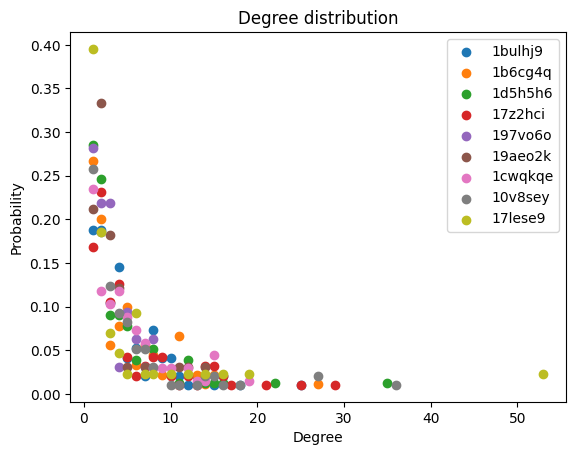

In [82]:
for post_graph in post_id_graph:
    x, y = compute_degree_distribution(post_id_graph[post_graph])
    plt.scatter(x, y)
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.title('Degree distribution')

plt.legend(post_id_graph.keys())
plt.show()

### Metriche sul Dibattito

**Coefficiente di clustering medio**

Tramite il coefficiente di clustring medio possiamo ottenere una misura golbale del grado di coesione degli utenti all'interno della dibattito, ovvero quanto gli utenti hanno interagito tra di loro all'interno della discussione in questione.

In [83]:
def compute_average_clustering_coefficient(graph):
    clustering_medio = graph.transitivity_avglocal_undirected()
    if clustering_medio != clustering_medio:
        clustering_medio = 0.0
    
    return clustering_medio

In [84]:
for post_df in post_id_dict.values():
    post_id = post_df['post_id'].iloc[0]
    for debate_id in post_df['debate_group'].unique():
        if debate_id != '0':
            debate_df = post_df[post_df['debate_group'] == debate_id]
            graph = create_graph_from_dataframe(debate_df)

In [86]:
def compute_debate_relevance(debate, graph):
    n_graph_nodes = graph.vcount()
    n_graph_edges = graph.ecount()
    n_nodes = debate.vcount()/n_graph_nodes
    n_edges = debate.ecount()/n_graph_edges
    avg_degree = degree_distribution(debate)
    clustering_coefficient = compute_average_clustering_coefficient(debate)
    return n_nodes + n_edges + avg_degree + clustering_coefficient


# Analisi del sentiment

Codice scalabile per calcolare il sentiment dei commenti.

Si implementa un sistema di **logging** per tracciare l'esecuzione del codice e facilitare il debugging.

In [30]:
# Configurazione del logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filemode='w')

In [31]:
# Funzione per caricare i dati
def load_data(file_path):
    logging.info(f'Caricamento dati da {file_path}')
    return pd.read_csv(file_path, encoding='utf-8', )

## Funzioni

### Salvare i risultati

In [32]:
import os

# Funzione per salvare i risultati 
def save_results(df, file_path):
    # Verifica se il file esiste
    if not os.path.isfile(file_path):
        df.to_csv(file_path, index=False, mode='w')
    else:
        df.to_csv(file_path, index=False, mode='a', header=False)
    logging.info(f'Salvati i risultati parziali in {file_path}')

### Preprocessing

Esiste un tokenizzatore già addestrato su dati testuali quali tweet o commenti social. Può essere utilizzato anche per il italiano, anche se è stato originariamente progettato per testi in stile tweet in inglese. Tuttavia, poiché i tweet possono contenere caratteristiche multilingue simili (ad esempio emoticon, hashtag, abbreviazioni), TweetTokenizer può funzionare ragionevolmente bene per la tokenizzazione di testi in altre lingue, inclusa l'italiano.

In [33]:
from nltk.tokenize import TweetTokenizer
import string
import spacy
from nltk.corpus import stopwords
import nltk
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [34]:
nlp = spacy.load("it_core_news_sm") # Carichiamo il modello italiano di spaCy

# Funzione per lemmatizzare una lista di token
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))  # Converto i token in una stringa e processo con spaCy
    return [token.lemma_ for token in doc]  # Estraggo i lemmi

In [35]:
# Si utilizza una libreria specifica per la tokenizzazione multilingue come spaCy, 
# che ha modelli pre-addestrati per molte lingue, tra cui l'italiano.

tokening = TweetTokenizer() # Tokenizzazione per i tweet
nltk.download('stopwords')
stop = stopwords.words('italian')   # Carichiamo le stopwords italiane     
punctuation = string.punctuation    # Carichiamo la punteggiatura

# Tengo le parole non e più perché potrebbero essere importanti per il sentimento
stop = [item for item in stop if item not in ["non", "più"]]

# Funzione per eseguire il preprocessing dei dati
def preprocess_data(df):
    
    # Quando abbiamo a che fare con il testo dei social media, di solito vogliamo identificare URL, 
    # hashtag e emoticon come oggetti separati e non tokenizzarli in singoli caratteri:
    comments_tokenized = df.apply(TweetTokenizer().tokenize)

    # Rimuoviamo le stopword
    comments_tokenized_stop = comments_tokenized.apply(lambda x: [item for item in x if item not in stop])
    
    # Rimuoviamo la punteggiatura
    comments_tokenized_stop_punct = comments_tokenized_stop.apply(lambda x: [item for item in x if item not in punctuation])

    # Lemmatizzazione
    comments_tokenized_new_stem = comments_tokenized_stop_punct.apply(lemmatize_tokens)

    # Unisco i token lemmatizzati per formare le frasi preprocessate
    preprocessed_comments = comments_tokenized_new_stem.apply(lambda x: " ".join(x))

    return preprocessed_comments

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/massimo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### NRC Emotion Lexicon

L'**NRC Emotion Lexicon** ha annotazioni influenti per le parole inglesi. Nonostante alcune differenze culturali, è stato dimostrato che la maggior parte delle norme affettive sono stabili attraverso le lingue. Pertanto, forniamo versioni del lessico in oltre 100 lingue traducendo i termini inglesi utilizzando Google Translate (agosto 2022).

Il lessico è quindi disponibile per l'inglese ma anche per numerose altre lingue, tra cui l'italiano!

In [36]:
import pandas as pd

Emotion_Lexicon = "../resources/NRC-Emotion-Lexicon.xlsx"
lexicon_df = pd.read_excel(Emotion_Lexicon, engine="openpyxl")

/home/massimo/Documents/data_analytics/project/reddit_debate_venv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [37]:
lexicon = {}
for word, pos, neg, ant, ang, dis, fea, joy, sad, sur, tru in zip(lexicon_df["Italian Translation (Google Translate)"], lexicon_df["Positive"], lexicon_df["Negative"], lexicon_df["Anticipation"], lexicon_df["Anger"], lexicon_df["Disgust"], lexicon_df["Fear"], lexicon_df["Joy"], lexicon_df["Sadness"], lexicon_df["Surprise"], lexicon_df["Trust"]): 
    value = []
    if pos:
        value.append("positive")
    if neg:
        value.append("negative")
    if ant:
        value.append("anticipation")
    if ang:
        value.append("anger")
    if dis:
        value.append("disgust")
    if fea:
        value.append("fear")
    if joy:
        value.append("joy")
    if sad:
        value.append("sadness")
    if sur:
        value.append("surprise")
    if tru:
        value.append("trust")
    lexicon[str(word).lower()] = value #lower case

In [38]:
# Funzione che calcola il sentiment con NRC-Emotion-Lexicon
def nrc_score(df):
    # Inizializzo i contatori per i sentimenti
    positive_count = 0
    negative_count = 0
    
    # Inizializzo un dizionario per contare le emozioni
    emotion_count = {
        "anticipation": 0,
        "anger": 0,
        "disgust": 0,
        "fear": 0,
        "joy": 0,
        "sadness": 0,
        "surprise": 0,
        "trust": 0
    }
    
    # Analizzo ogni parola nella frase
    for word in df.split():  # La funzione split divide la stringa dagli spazi
        word = word.lower()
        if word in lexicon:
            values = lexicon[word]
            # Conto i sentimenti
            if "positive" in values:
                positive_count += 1
            if "negative" in values:
                negative_count += 1
            # Conta le emozioni
            for emotion in emotion_count.keys():
                if emotion in values:
                    emotion_count[emotion] += 1

    # Determino il sentimento prevalente
    if positive_count > negative_count:
        predominant_sentiment = "positive"
    elif negative_count > positive_count:
        predominant_sentiment = "negative"
    else:
        predominant_sentiment = "neutral"  

    # Determina l'emozione prevalente
    if all(value == 0 for value in emotion_count.values()):
        predominant_emotion = "none"  # Nessuna emozione prevalente
    else:
        predominant_emotion = max(emotion_count, key=emotion_count.get)
    
    # Restituisco una lista con i due valori prevalenti
    return [predominant_sentiment, predominant_emotion]

### Italian BERT Sentiment model

https://huggingface.co/neuraly/bert-base-italian-cased-sentiment

Questo modello esegue l'analisi del sentiment sulle frasi italiane. È stato addestrato a partire da un'istanza di bert-base-italian-cased, e messo a punto su un dataset italiano di tweets, raggiungendo su quest'ultimo l'82% di precisione.

In [39]:
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm



def bert_score(df):

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

    # Load the model, use .cuda() to load it on the GPU
    bert_model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment")
    bert_model.eval()  # Imposta il modello in modalità valutazione

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        sentence = row.comment_body

        input_ids = tokenizer.encode(sentence, add_special_tokens=True, truncation=True, max_length=512)

        # Create tensor, use .cuda() to transfer the tensor to GPU if available
        tensor = torch.tensor(input_ids).long().unsqueeze(0)
        if torch.cuda.is_available():
            tensor = tensor.cuda()
            bert_model.cuda()

        # Call the model and get the logits
        with torch.no_grad():
            logits = bert_model(tensor)
        
        # Remove the fake batch dimension
        logits = logits.logits.squeeze(0)

        # Apply softmax to get probabilities
        proba = nn.functional.softmax(logits, dim=0)

        # Unpack the tensor to obtain negative, neutral and positive probabilities
        negative, neutral, positive = proba

        # Assign probabilities to DataFrame
        df.loc[index, 'negative'] = proba[0].item()
        df.loc[index, 'neutral'] = proba[1].item()
        df.loc[index, 'positive'] = proba[2].item()

    # Determine the sentiment label based on maximum probability
    df['BERT'] = df[['negative', 'positive', 'neutral']].idxmax(axis=1)

    db = df[['comment_id', 'post_id', 'debate_group', 'comment_user_name', 'comment_body', 'comment_score', 'preprocessed_comment', 'negative', 'neutral', 'positive', 'BERT']]

    # Salvo i risultati in un file
    save_results(db, '../results/BERT_results.csv')

    # Rimuovo le colonne di probabilità
    df.drop(['negative', 'neutral', 'positive'], axis=1, inplace=True)

/home/massimo/Documents/data_analytics/project/reddit_debate_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### FEEL-IT: Emotion and Sentiment Classification for the Italian Language

https://huggingface.co/MilaNLProc/feel-it-italian-sentiment

Utilizzo un altro classificatore di sentiment, dotato di un corpus di riferimento di post Twitter italiani annotati con quattro emozioni fondamentali: rabbia, paura, gioia, tristezza. Comprimendoli, possiamo anche fare l’analisi del sentiment. 

PAPER: https://aclanthology.org/2021.wassa-1.8.pdf

In [40]:
from feel_it import SentimentClassifier
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()
sentiment_classifier = SentimentClassifier()

In [41]:
def feel_score(df):
    feel_it_scores = []
    for sentence in df['preprocessed_comment']:
        feel_it_scores.append(sentiment_classifier.predict([sentence])[0])
    df['FEEL_IT'] = feel_it_scores
    db = df[['comment_id', 'post_id', 'debate_group', 'comment_user_name', 'comment_body', 'comment_score', 'preprocessed_comment', 'FEEL_IT']]

    # Salvo i risultati in un file CSV
    save_results(db, "../results/FEEL_IT_results.csv")


In [42]:
def emotion_score(df):
    emotion_scores = []
    for sentence in df['preprocessed_comment']:
        emotion_scores.append(emotion_classifier.predict([sentence])[0])
    df['EMOTION'] = emotion_scores
    db = df[['comment_id', 'post_id', 'debate_group', 'comment_user_name', 'comment_body', 'comment_score', 'preprocessed_comment', 'EMOTION']]
    save_results(db, "../results/EMOTION_results.csv")


### MULTILINGUAL: bert-base-multilingual-uncased-sentiment 

https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment 

Si tratta di un modello bert-base-multilingue-uncased ottimizzato per l'analisi del sentiment sulle recensioni dei prodotti in sei lingue: inglese, olandese, tedesco, francese, spagnolo e **italiano**. Prevede il sentiment della recensione sotto forma di numero di stelle (tra 1 e 5).

In [43]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment").to("cuda")

In [44]:
from tqdm import tqdm

def multilingual_score(df):
    # Crea colonne per memorizzare le probabilità
    df['1'] = 0
    df['2'] = 0
    df['3'] = 0
    df['4'] = 0
    df['5'] = 0

     # Itera attraverso ogni riga del DataFrame
    for index, row in tqdm(df.iterrows()):
        sentence = row.preprocessed_comment
            
        input_ids = tokenizer.encode(sentence, add_special_tokens=True, truncation=True, max_length=512)
            
        # Create tensor, use .cuda() to transfer the tensor to GPU
        tensor = torch.tensor(input_ids).long()
        # Fake batch dimension
        tensor = tensor.unsqueeze(0).to("cuda")

        # Call the model and get the logits
        logits = model(tensor)
        # Remove the fake batch dimension
        logits = logits.logits.squeeze(0)

        # The model was trained with a Log Likelyhood + Softmax combined loss, hence to extract probabilities we need a softmax on top of the logits tensor
        proba = nn.functional.softmax(logits, dim=0)

        # Aggiungi le probabilità alle colonne appropriate
        proba = proba.to("cpu")
        df.loc[index, '1'] = proba[0].item()
        df.loc[index, '2'] = proba[1].item()
        df.loc[index, '3'] = proba[2].item()
        df.loc[index, '4'] = proba[3].item()
        df.loc[index, '5'] = proba[4].item()

    # Calcola il sentimento prevalente
    df['MULTILINGUAL'] = df[['1', '2', '3', '4', '5']].idxmax(axis=1)
    db = df[['comment_id', 'post_id', 'debate_group', 'comment_user_name', 'comment_body', 'comment_score', 'preprocessed_comment', '1', '2', '3', '4', '5', 'MULTILINGUAL']]
    df.drop(columns=['1', '2', '3', '4', '5'], inplace=True)

    # Tentare di convertire i valori della colonna 'MULTILINGUAL' in numerici, ignorando gli errori
    df['sentiment_pred_numeric'] = pd.to_numeric(df['MULTILINGUAL'], errors='coerce')

    # Applicare le trasformazioni solo ai valori numerici
    df.loc[df['sentiment_pred_numeric'] >= 4, 'MULTILINGUAL'] = 'positive'
    df.loc[df['sentiment_pred_numeric'] <= 2, 'MULTILINGUAL'] = 'negative'
    df.loc[df['sentiment_pred_numeric'] == 3, 'MULTILINGUAL'] = 'neutral'

    # Rimuovere la colonna temporanea utilizzata per la conversione
    df.drop(columns=['sentiment_pred_numeric'], inplace=True)
    
    save_results(db, "../results/MULTILINGUAL_results.csv")

### Predirre sentiment ed emotion con i modelli

In [45]:
# Funzione per predire il sentiment usando un modello specifico
def predict(model_name, df):
    # Implementa la logica di predizione per ciascun modello
    if(model_name == 'NRC'):
        tqdm.pandas()  # Per visualizzare la progress bar con tqdm
        df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
        save_results(df, '../results/NRC_results.csv')
    elif(model_name == 'BERT'):
        tqdm.pandas()  # Per visualizzare la progress bar con tqdm
        df = bert_score(df)
    elif(model_name == 'FEEL'):
        tqdm.pandas()  # Per visualizzare la progress bar con tqdm
        df = feel_score(df)
    elif(model_name == 'MULTILINGUAL'):
        tqdm.pandas()  # Per visualizzare la progress bar con tqdm
        df = multilingual_score(df)
    elif(model_name == 'EMOTION'):
        tqdm.pandas()  # Per visualizzare la progress bar con tqdm        
        df = emotion_score(df)
    return df

### Etichettatura

Si procede etichettando il dataset risultante per maggioranza: si comparano i risultati dei tre modelli più utilizzati e, il sentimento che prevale, sarà quello associato al dato commento. Quando ho tre sentimenti differenti, imposto "neutral".

In [46]:
from collections import Counter

def majority_vote(row):
    # Ottieni le predizioni per la riga corrente
    predictions = [row['BERT'], row['FEEL_IT'], row['MULTILINGUAL']]
    
    # Conta le occorrenze di ogni predizione
    vote_counts = Counter(predictions)
    
    # Trova la predizione con il maggior numero di voti
    majority_vote = vote_counts.most_common(1)[0][0]
    
    return majority_vote

def apply_majority_vote(df):
    # Applica la funzione majority_vote a ogni riga del DataFrame
    df['majority_vote'] = df.apply(majority_vote, axis=1)
    return df

## Calcolo di sentiment ed emotion di una discussione

In [57]:
def sentiment_and_emotion_discussion(df):
    # Raggruppare per emozione e calcolare il punteggio totale ponderato per ogni emozione
    sentiment_scores = df.groupby('majority_vote')['comment_score'].sum()
    emotion_scores = df.groupby('EMOTION')['comment_score'].sum()


    # Determinare l'emozione prevalente per ogni gruppo di discussione
    prevalent_sentiment = df.groupby('debate_group').apply(lambda group: sentiment_scores.idxmax())
    prevalent_emotion = df.groupby('debate_group').apply(lambda group: emotion_scores.idxmax())


 # Creare il dataframe discussion con le informazioni desiderate
    discussion = pd.DataFrame({
        'post_id': df['post_id'].iloc[0],
        'debate_group': prevalent_emotion.index,
        'sentiment': prevalent_sentiment.values,
        'emotion': prevalent_emotion.values
    })

    # Salvare i risultati in un file CSV
    save_results(discussion, '../results/discussion_sentiment_and_emotion.csv')

## Calcolo pesato del sentiment di un post

In [108]:
import numpy as np


def post_sentiment(df, relevance):

    # Mappa le etichette 'positive', 'negative', 'neutral' a 1, -1, 0 rispettivamente
    sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
    df['sentiment_numeric'] = df['sentiment'].map(sentiment_mapping)
    
    # Verifica che il numero di righe nel DataFrame df corrisponda alla lunghezza di relevance
    if len(df) != len(relevance):
        raise ValueError("La lunghezza di relevance deve corrispondere al numero di righe nel DataFrame df.")
    
    # Converti relevance in un array NumPy per la moltiplicazione
    relevance_array = np.array(relevance)
    
    # Calcola l'importanza pesata del sentiment numerico per ciascuna discussione
    weighted_sentiments = df['sentiment_numeric'] * relevance_array
    
    # Calcola il sentiment totale del post sommando tutte le importanze pesate
    post_sentiment = weighted_sentiments.sum()
    
    return post_sentiment

## Main

In [109]:
# Caricamento della configurazione
with open("../resources/config.yaml", 'r') as file:
    config = yaml.safe_load(file)

In [60]:
 # Caricamento dei dati (Si utilizza il dataset generato al termine dell'analisi dei grafi, 
 # composto esclusivamente dai commenti che hanno contribuito attivamente ai dibattiti di ciascun post. 
 # Lo si vuole analizzare per capire se tali commenti abbiano un sentiment positivo o negativo.)
df = load_data(config['data']['input_path'])

2024-06-27 22:17:16,078 - INFO - Caricamento dati da ../debate_dataset.csv


In [61]:
# Creo una lista di id_post unici
id_posts = df['post_id'].unique()

print(id_posts)
print("Numero di post unici: ", len(id_posts))


# Creo una lista di id_post unici
debate_groups = df['debate_group'].unique()

['1bulhj9' '1b6cg4q' '1d5h5h6' '17z2hci' '197vo6o' '19aeo2k' '1cwqkqe'
 '10v8sey' '17lese9']
Numero di post unici:  9


In [62]:
# Filtro il dataset in modo tale da avere solo i commenti relativi ad un post

# Itero sugli id dei post
for id_post in id_posts:
    # Filtro il dataframe per l'id del post corrente
    df_filtered_post = df[df['post_id'] == id_post]
    for debate_group in df_filtered_post['debate_group'].unique():
        # Filtro il dataframe per il gruppo di dibattito corrente
        df_filtered_group = df_filtered_post[df_filtered_post['debate_group'] == debate_group]
        
        # Stampo il numero di commenti per il post corrente e gruppo di dibattito
        print(f"Numero di commenti per il post {id_post} che hanno partecipato al debate group {debate_group} : {len(df_filtered_group)}")
        
        # Isolo le uniche colonne che mi interessano
        df_fil = df_filtered_group[['comment_id', 'comment_body']].copy()
        
        # Estraggo solo i commenti
        comments = df_fil['comment_body']
        
        # Preprocesso i commenti
        preprocessed_comments = preprocess_data(comments)
        
        df_filtered_group["preprocessed_comment"] = preprocessed_comments
        
        # Utilizzo un indice booleano per assegnare direttamente i valori nel DataFrame originale
        df.loc[df_filtered_group.index, 'preprocessed_comment'] = preprocessed_comments
        
        # Salvo i risultati parziali
        save_results(df.loc[df_filtered_group.index, ['comment_id', 'comment_body', 'preprocessed_comment']], "../results/preprocessed_comments.csv")

        
        # Predizioni con i modelli
        models = config['models']
        for mod in models:
            predict(mod, df_filtered_group)
        
        # Salvo i risultati parziali
        save_results(df_filtered_group, "../results/predictions.csv")

        # Etichetto il sentimento prevalente
        apply_majority_vote(df_filtered_group)

        # Salvo i risultati parziali
        save_results(df_filtered_group, "../results/majority_vote.csv")

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 1 : 199


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:17:17,895 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:17:17,904 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/199 [00:00

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 2 : 8


  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 3 : 16


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 4 : 6


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 5 : 5


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 6 : 2


  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 7 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1bulhj9 che hanno partecipato al debate group 8 : 4


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1b6cg4q che hanno partecipato al debate group 9 : 168


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:18:31,623 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:18:31,632 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/168 [00:00

Numero di commenti per il post 1b6cg4q che hanno partecipato al debate group 10 : 14


  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 1b6cg4q che hanno partecipato al debate group 11 : 14


  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 1b6cg4q che hanno partecipato al debate group 12 : 11


  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 1b6cg4q che hanno partecipato al debate group 13 : 5


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1b6cg4q che hanno partecipato al debate group 14 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1d5h5h6 che hanno partecipato al debate group 15 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1d5h5h6 che hanno partecipato al debate group 16 : 18


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 1d5h5h6 che hanno partecipato al debate group 17 : 36


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:19:45,683 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:19:45,686 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/36 [00:00<

Numero di commenti per il post 1d5h5h6 che hanno partecipato al debate group 18 : 103


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:19:57,427 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:19:57,432 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/103 [00:00

Numero di commenti per il post 1d5h5h6 che hanno partecipato al debate group 19 : 4


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1d5h5h6 che hanno partecipato al debate group 20 : 5


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 17z2hci che hanno partecipato al debate group 21 : 263


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:20:34,888 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:20:34,898 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/263 [00:00

Numero di commenti per il post 17z2hci che hanno partecipato al debate group 22 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 17z2hci che hanno partecipato al debate group 23 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 197vo6o che hanno partecipato al debate group 24 : 27


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:21:52,021 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:21:52,025 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/27 [00:00<

Numero di commenti per il post 197vo6o che hanno partecipato al debate group 25 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 197vo6o che hanno partecipato al debate group 26 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 197vo6o che hanno partecipato al debate group 27 : 16


  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 28 : 4


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 29 : 4


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 30 : 28


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 31 : 2


  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 32 : 12


  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 33 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 19aeo2k che hanno partecipato al debate group 34 : 3


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1cwqkqe che hanno partecipato al debate group 35 : 5


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 1cwqkqe che hanno partecipato al debate group 36 : 161


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:22:28,044 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:22:28,049 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/161 [00:00

Numero di commenti per il post 1cwqkqe che hanno partecipato al debate group 37 : 5


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 10v8sey che hanno partecipato al debate group 38 : 203


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:23:11,295 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:23:11,301 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/203 [00:00

Numero di commenti per il post 10v8sey che hanno partecipato al debate group 39 : 10


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 10v8sey che hanno partecipato al debate group 40 : 5


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 10v8sey che hanno partecipato al debate group 41 : 10


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

Numero di commenti per il post 10v8sey che hanno partecipato al debate group 42 : 4


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 10v8sey che hanno partecipato al debate group 43 : 7


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Numero di commenti per il post 17lese9 che hanno partecipato al debate group 44 : 107


/tmp/ipykernel_21746/76317065.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_group["preprocessed_comment"] = preprocessed_comments
2024-06-27 22:24:17,087 - INFO - Salvati i risultati parziali in ../results/preprocessed_comments.csv
/tmp/ipykernel_21746/3195519703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NRC'] = df["preprocessed_comment"].apply(nrc_score)
2024-06-27 22:24:17,093 - INFO - Salvati i risultati parziali in ../results/NRC_results.csv
  0%|          | 0/107 [00:00

Numero di commenti per il post 17lese9 che hanno partecipato al debate group 45 : 2


  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_21746/2891569241.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'negative'] = proba[0].item()
/tmp/ipykernel_21746/2891569241.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'neutral'] = proba[1].item()
/tmp/ipykernel_21746/2891569241.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

# Analisi
A questo punto si analizzano i risultati ottenuti.

In [63]:
# Voglio analizzare il sentiment di ciascuna discussione e salvarlo in un file
df = load_data("../results/majority_vote.csv")

# Filtro il dataset dei risultati ottenuto prima per avere solo le colonne che mi interessano
df = df[['comment_id', 'post_id', 'debate_group', 'comment_body', 'comment_score', 'EMOTION', 'majority_vote']] 

2024-06-27 22:24:49,332 - INFO - Caricamento dati da ../results/majority_vote.csv


In [64]:
debate_groups = df['debate_group'].unique()

for debate_group in debate_groups:
    # Filtro il dataframe per il gruppo di dibattito corrente
    df_filtered_group = df[df['debate_group'] == debate_group]
    
    # Applico la funzione sentiment_discussione per ottenere il sentiment prevalente per ciascuna discussione
    sentiment_and_emotion_discussion(df_filtered_group)

/tmp/ipykernel_21746/2588029746.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prevalent_sentiment = df.groupby('debate_group').apply(lambda group: sentiment_scores.idxmax())
/tmp/ipykernel_21746/2588029746.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prevalent_emotion = df.groupby('debate_group').apply(lambda group: emotion_scores.idxmax())
2024-06-27 22:24:49,369 - INFO - Salvati i risultati p

In [65]:
sentiment_post = load_data("../results/discussion_sentiment_and_emotion.csv")

2024-06-27 22:24:49,613 - INFO - Caricamento dati da ../results/discussion_sentiment_and_emotion.csv


In [153]:
relevances = {}
for post_df in post_id_dict.values():
    post_id = post_df['post_id'].iloc[0]
    for debate_id in post_df['debate_group'].unique():
        if debate_id != '0':
            debate_df = post_df[post_df['debate_group'] == debate_id]
            debate_graph = create_graph_from_dataframe(debate_df)
            relevance = compute_debate_relevance(debate_graph, graph)
            relevances[f'{debate_id}'] = relevance

print(relevances)

{'1': 142.45813311688312, '2': 11.833333333333332, '3': 16.2, '4': 8.5, '5': 8.5, '6': 4.0, '7': 5.5, '8': 7.0, '9': 126.0712037037037, '10': 15.045454545454545, '11': 16.0, '12': 17.5, '13': 8.5, '14': 5.5, '15': 5.0, '16': 17.6, '17': 31.741964285714285, '18': 76.74932659932661, '19': 6.166666666666666, '20': 7.0, '21': 182.99597794495756, '22': 5.0, '23': 5.0, '24': 25.176470588235293, '25': 5.5, '26': 5.0, '27': 16.40909090909091, '28': 6.166666666666666, '29': 6.0, '30': 25.5, '31': 4.0, '32': 14.0, '33': 5.0, '34': 5.5, '35': 8.5, '36': 116.73436471362739, '37': 7.0, '38': 144.94194841517495, '39': 11.5, '40': 7.0, '41': 12.0, '42': 7.0, '43': 8.8, '44': 79.36907841837238, '45': 4.0}


In [180]:
import random

post_sentiment_df = sentiment_post[['post_id', 'debate_group', 'sentiment_numeric']]
sentiment = {}

post_sentiment_df['true_relevance'] = None

# Itera su ogni riga del DataFrame
for index, row in post_sentiment_df.iterrows():
    debate_id = row['debate_group']
    single_post_sentiment = post_sentiment_df[post_sentiment_df['debate_group'] == debate_id].iloc[0]
    # Ottieni il valore di relevance dal dizionario relevances
    relevance = relevances.get(f'{debate_id}', None)  # Utilizza get per evitare KeyError
    # Assegna il valore di relevance alla colonna 'relevance'
    post_sentiment_df.at[index, 'true_relevance'] = relevance * single_post_sentiment['sentiment_numeric']

summed_df = post_sentiment_df.groupby('post_id').agg({
    'true_relevance': 'sum'
}).reset_index()

# Verifica il risultato
print(summed_df)

# Salva i risultati in un file CSV
save_results(summed_df, "../results/post_sentiment.csv")

/tmp/ipykernel_21746/227834232.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_sentiment_df['true_relevance'] = None
2024-06-27 23:24:27,930 - INFO - Salvati i risultati parziali in ../results/post_sentiment.csv


   post_id true_relevance
0  10v8sey    -184.241948
1  17lese9     -83.369078
2  17z2hci    -192.995978
3  197vo6o     -52.085561
4  19aeo2k      35.666667
5  1b6cg4q    -188.616658
6  1bulhj9    -171.991466
7  1cwqkqe    -115.234365
8  1d5h5h6    -112.515993
